In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import functions
import plot
import clean
import models

from sklearn.preprocessing import Normalizer

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of functions failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/jaime/Documents/dai/projects/final/psyop_selection_analysis/notebooks/../src/functions.py", line 58, in <module>
    def train_split(X, y, test_size=.2, seed=seed):
NameError: name 'seed' is not def

## Setup variables

In [67]:
poas_rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6}
sfas_rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6, 'SFC': 7, 'SSGT': 6, 'SRA': 4, 'SN': 3, 'AF': 4}
columns = ['DEP', 'PT', 'AGE', 'GT', 'EL', 'SC', 'CO', 'FA', 'ST']
new_labels = {'SEC': 'SECURITY CLEARANCE', 'AB': 'AIRBORNE', 'RGR': 'RANGER', 'DEP': 'DEPENDENTS', 'LANG': 'LANGUAGE', 'GT': 'GENERTAL TECHNICAL', 'EL': 'ELECTRONICS', 'SC': 'SURVEILLANCE AND COMMUNICATIONS', 'CO': 'COMBAT', 'FA': 'FIELD ARTILLERY', 'ST': 'SKILLED TECHNICAL', 'CODE': 'SELECT'}

poas_filepath = '../data/poas'
poas_filenames = ['poas16.xlsx', 'poas17.xlsx', 'poas18.xlsx', 'poas19.xlsx', 'poas20.xlsx', 'poas21.xlsx', 'poas22.xlsx']

sfas_filepath = '../data/sfas'
sfas_filenames = ['sfas16.xlsx', 'sfas17.xlsx', 'sfas18.xlsx', 'sfas19.xlsx', 'sfas20.xlsx', 'sfas21.xlsx', 'sfas22.xlsx']

## Data Import & Cleaning

In [68]:
poas = clean.clean_data(poas_filepath, poas_filenames, columns, 'POAS')
sfas = clean.clean_data(sfas_filepath, sfas_filenames, columns, 'SFAS')

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


## Initial Overview

View of overall data

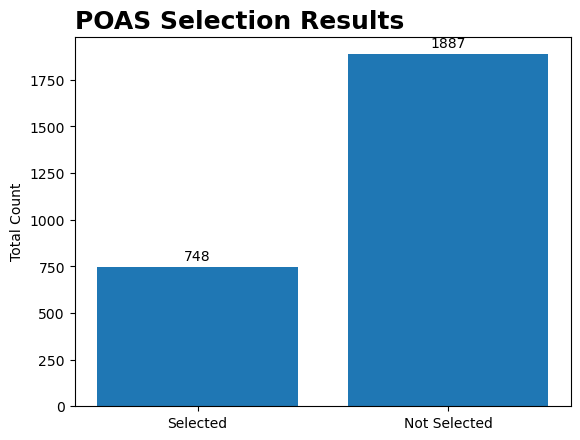

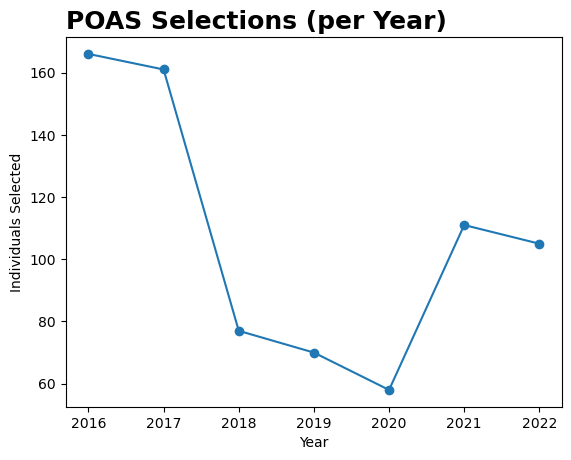

In [69]:
poas_selected = functions.equal_column_val(poas, 'RESULT', 'SELECTED')
poas_not_selected = functions.not_column_val(poas, 'RESULT', 'SELECTED')

outcome = [poas_selected.RESULT.count(), poas_not_selected.RESULT.count()]

plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'POAS Selection Results', 'Total Count')
plot.annual_line_plot(poas_selected, 'POAS Selections (per Year)', 'Year', 'Individuals Selected')

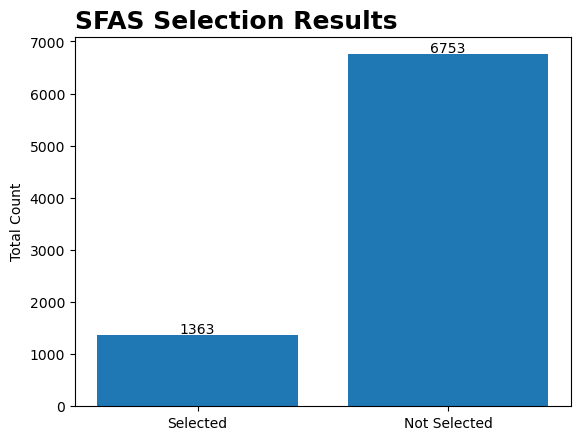

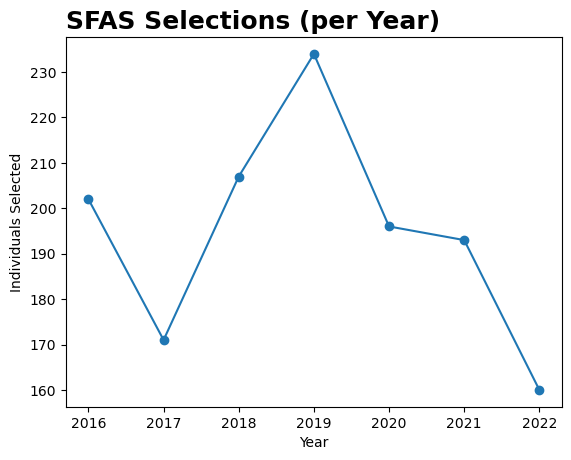

In [70]:
sfas_selected = functions.equal_column_val(sfas, 'RESULT', 'SELECTED')
sfas_not_selected = functions.not_column_val(sfas, 'RESULT', 'SELECTED')

outcome = [sfas_selected.RESULT.count(), sfas_not_selected.RESULT.count()]

plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'SFAS Selection Results', 'Total Count')
plot.annual_line_plot(sfas_selected, 'SFAS Selections (per Year)', 'Year', 'Individuals Selected')

24
25


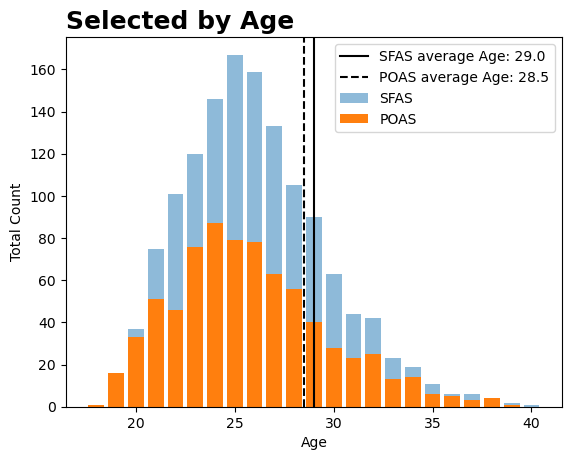

In [71]:
poas_ages = poas_selected.groupby('AGE').size().reset_index(name='counts')
sfas_ages = sfas_selected.groupby('AGE').size().reset_index(name='counts')
poas_most_age = poas_ages.loc[poas_ages['counts'].idxmax(), 'AGE']
sfas_most_age = sfas_ages.loc[sfas_ages['counts'].idxmax(), 'AGE']

print(poas_most_age)
print(sfas_most_age)

plot.age_bar(poas_ages, sfas_ages, 'AGE', 'counts', 'Selected by Age', 'Age', 'Total Count')

## Key Features

Numerical look at features that are often considered "important"

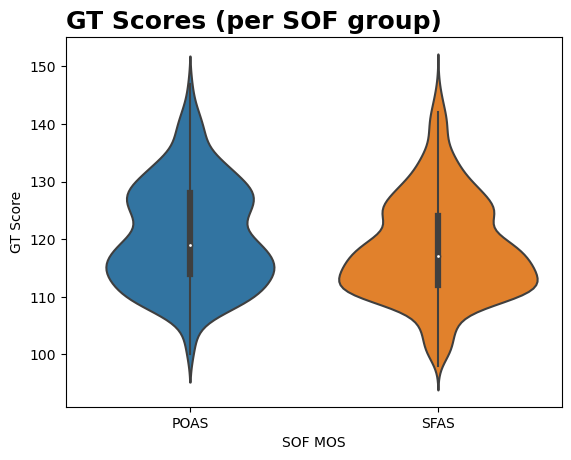

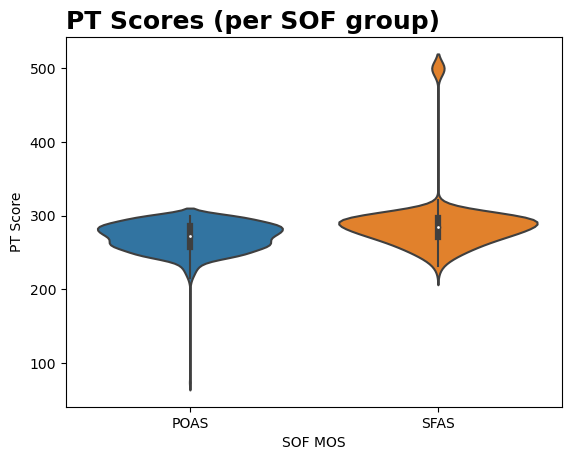

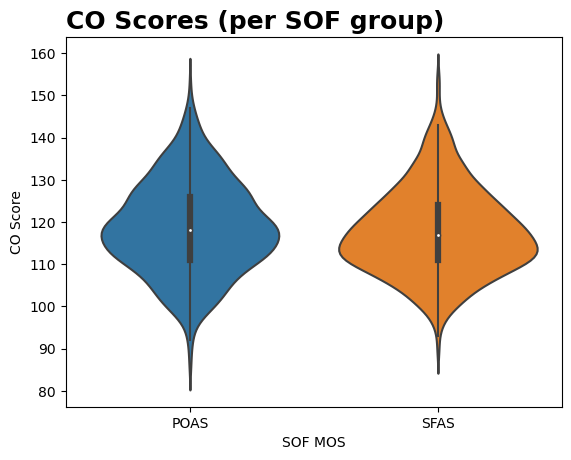

In [72]:
both = [poas, sfas]
combined = functions.combined(both)
combined_selected = functions.equal_column_val(combined, 'RESULT', 'SELECTED')

plot.violin_plot('GROUP', 'GT', combined_selected, 'GT Scores (per SOF group)', 'SOF MOS', 'GT Score')
plot.violin_plot('GROUP', 'PT', combined_selected, 'PT Scores (per SOF group)', 'SOF MOS', 'PT Score')
plot.violin_plot('GROUP', 'CO', combined_selected, 'CO Scores (per SOF group)', 'SOF MOS', 'CO Score')

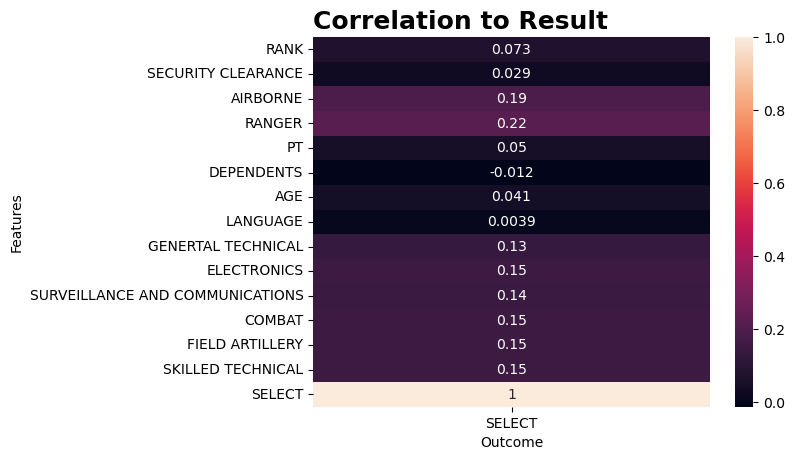

In [73]:
combined = combined.drop('YEAR', axis=1)
functions.new_labels(combined, new_labels)
functions.replace_vals(combined, 'RANK', sfas_rank_vals)
functions.replace_vals(combined, 'RANK', poas_rank_vals)
plot.select_correlation(combined, 'Correlation to Result', 'Outcome', 'Features')

## POAS Pre-Model

In [74]:
functions.replace_vals(poas, 'RANK', poas_rank_vals)
poas2 = poas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)
poasX, poasX2, poasy = functions.return_x_y(poas2, 'CODE')
poas_split = functions.train_split(poasX2, poasy)

## POAS Info

In [75]:
poas_info = sm.Logit(poas_split[2], poas_split[0]).fit()
print(poas_info.summary())

Optimization terminated successfully.
         Current function value: 0.566647
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   CODE   No. Observations:                 2108
Model:                          Logit   Df Residuals:                     2093
Method:                           MLE   Df Model:                           14
Date:                Fri, 03 Feb 2023   Pseudo R-squ.:                 0.04988
Time:                        16:40:35   Log-Likelihood:                -1194.5
converged:                       True   LL-Null:                       -1257.2
Covariance Type:            nonrobust   LLR p-value:                 5.425e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -32.9834     27.492     -1.200      0.230     -86.867      20.900
x2            16.9829     58.

## POAS Logistic Regression Model

Single Logistic Regression Model

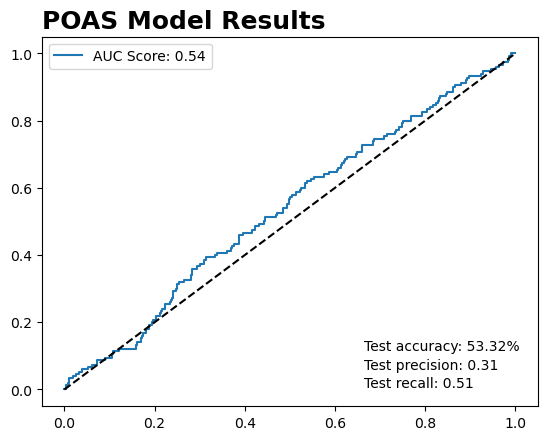

In [76]:
poas_single_model = models.regression_model(poas_split[0], poas_split[1], poas_split[2], poas_split[3], 'POAS Model Results', 'Simple Logistic Regression')

KFold Model

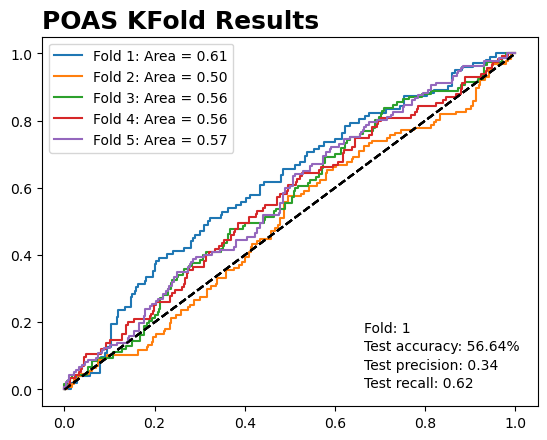

In [77]:
poas_multi = models.multiple_regression_model(poasX, poasy, 5, 'POAS KFold Results')

## SFAS Pre-Model


In [78]:
functions.replace_vals(sfas, 'RANK', sfas_rank_vals)
sfas2 = sfas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)
sfasX, sfasX2, sfasy = functions.return_x_y(sfas2, 'CODE')
sfas_split = functions.train_split(sfasX2, sfasy)

## SFAS Info

In [79]:
sfas_info = sm.Logit(sfas_split[2], sfas_split[0]).fit()
print(sfas_info.summary())

Optimization terminated successfully.
         Current function value: 0.408221
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   CODE   No. Observations:                 6492
Model:                          Logit   Df Residuals:                     6477
Method:                           MLE   Df Model:                           14
Date:                Fri, 03 Feb 2023   Pseudo R-squ.:                 0.09793
Time:                        16:40:36   Log-Likelihood:                -2650.2
converged:                       True   LL-Null:                       -2937.9
Covariance Type:            nonrobust   LLR p-value:                8.961e-114
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            68.4667     18.989      3.606      0.000      31.249     105.684
x2           -81.5104     47.

## SFAS Logistic Regression Model

Single Logistic Regression Model

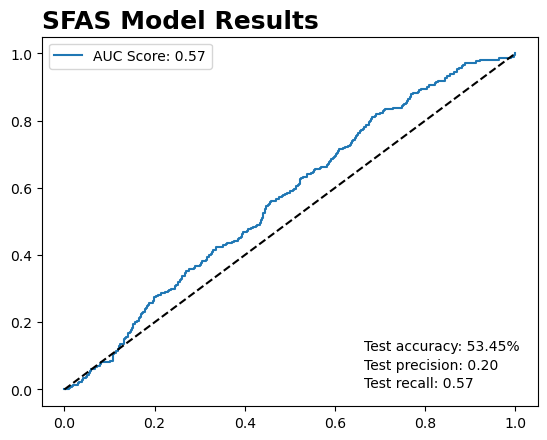

In [80]:
sfas_single_model = models.regression_model(sfas_split[0], sfas_split[1], sfas_split[2], sfas_split[3], 'SFAS Model Results')

KFold Model

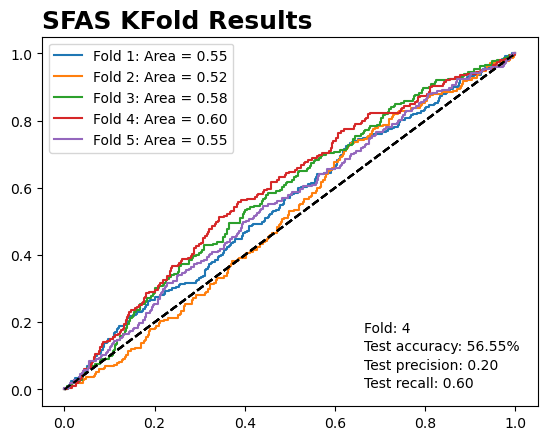

In [81]:
sfas_multi = models.multiple_regression_model(sfasX, sfasy, 5, 'SFAS KFold Results')